# P3 - Behavioral cloning

-----------------------

# Data collection and augmentation

First step in the process was getting the images for the training rounds, those come from both data augmentation and by recording new driving sessions with the simulator.

Driving the car properly for training was not so easy, I found the sample dataset having a smoother input and it's training lead to accurate results.
This is due to the keyboard input that produce hard turns and make the trained model more "wobbling".

At first I used the dev version, using the mouse seemed an interesting thing to have smooth angles, but it ends up to be hard to control, and I was producing bad data.
(as a result, I started deleting some batch of images when I was going out of road, so in the cleanup below, I'm filtering out csv lines leading to inexistents files).
Also I liked in the stable version, that 3 pictures are taken, it allow to produce a lot more training data, expecially useful for "recovery" normal angles.

I'm considering the left/right images, correcting the angle of 0.20 (in the direction of the center of the road).

Using a throttle/brake adjustment based on the predicted steer I was able to get good results, and to train a model that complete the first track using only the Udacity samples.
On a second round, I refined the model with my recordings (shuffled and applying a random variant at every iteration), using a little more of the 20% of the sample size for validation.

To parse the CSV, validate that the images exist and dealing with different recording session I created the `ImageSet` class in the `image.py`. It is used to collect all the center/left/right images and save them with the "corrected" steer. It features shuffleing slicing and composition of multiple datasets.

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [3]:
# get the images and the steer angles
# clean up the images, considering only ones leading to existing files
# the collected images are quite big, and are not part of this repository


from images import *
sample_set = get_sample_set()
training_set = get_training_set()
refinement_set = get_refinement_set_1() + get_refinement_set_2()

Parsing /home/dario/tmp/driverecords/data 24108
Parsing /home/dario/tmp/driverecords 2025
Parsing /home/dario/tmp/driverecords/30 morning session 915
Parsing /home/dario/tmp/driverecords/full_screen 633


In [3]:
# Import what we need
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2

## Loaded the sample set

Let's see some random image for the training set (this is the first group of my recording).  
A positive angle means the car will turn right, negative means left.

In the normalization, when training I choose randomly one of the variations of the original image:
the original or a horizontal flip (with inverted steer).
Both of them are cutted top-bottom so to remove the car hood and part of the sky (that is not relevant).
I'm also using the Keras ImageDataGenerator, to produce random rotations of up to 5°.

Here, for a random image I display the variations.
For the track 1, normalizing the luminosity via the Y channel, doesn't seem useful, as the track is constantly bright. Surely it could be useful for track 2.

Parsing /home/dario/tmp/driverecords/data 24108
Udacity sample extract - 1 images in the set.
0.548816


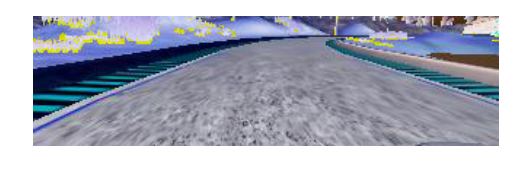

0.548816


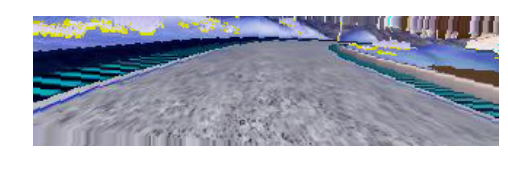

0.548816


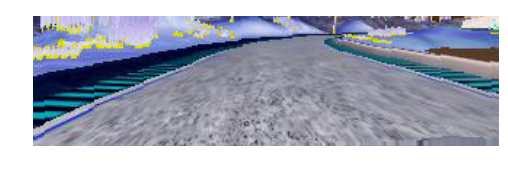

0.548816


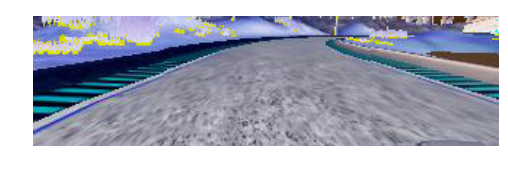

-0.548816


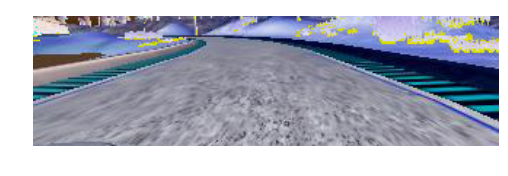

-0.548816


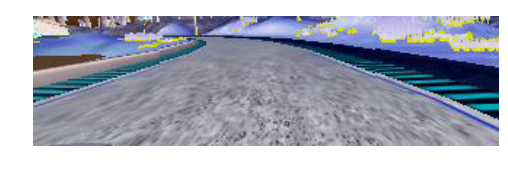

-0.548816


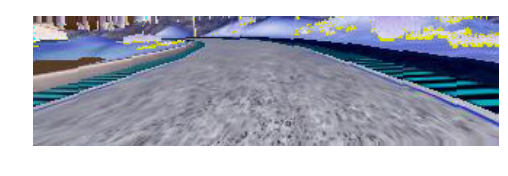

-0.548816


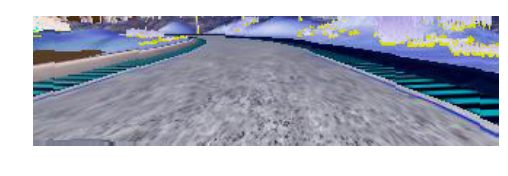

In [5]:
from normalization import *

show_variations()

# Model

Model is defined in the model.py using Keras, here we'll just import it.
I started adapting the NVIDIA architectural found in the 
[End to End Learning for Self-Driving Cars](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).
The original model itself is made of 5 convnet, followed by other 5 Dense layers.
I added a Dropout layer set at 20% to reduce overfitting, and I added a pooling layer (MaxPooling 2x2) after the first 3 convnet, to reduce the model size.
On my machine, using GPU, the Pooling helped fit the graphic card memory, using a batch size of 128.

In [7]:
from model import get_model
model = get_model()

Loaded model from disk


# Training

For the training I used the adam optimized and the mean_squared_error as loss function.

Using Keras generator to load images on batches was required given the large size of the dataset images.
The `normalization.py` contains the generator, it randomize the datasets on every epoch and for every image choose to get the original or an horizontal flip, training on a reverse steer value.

I also found it useful to slighly cut the images, to remove the car hood and the top part of the sky.  
Images are then cutted like this `img[50:-20, :]` (50px top, 20 pixels bottom)


In [ ]:
model.compile(
    optimizer='adam',
    loss='mse'
)

print("Training from %s" % selected)
tot_training_samples = len(selected)
nb_val_samples = tot_training_samples * 20 // 100
print("Using validation set of %d" % nb_val_samples)
# split validation set and training set
selected.shuffle()
selected, validation_set = selected[:-nb_val_samples], selected[-nb_val_samples:]

num_epochs = 5
for epoch in range(num_epochs):
    # the generator produce 8 variations for every single image
    model.fit_generator(generator=img_set_generator_factory(selected, batch_size=8),
                        validation_data=img_set_generator_factory(validation_set,
                                                                  batch_size=8),
                        nb_val_samples=len(validation_set) * 8,
                        samples_per_epoch=len(selected) * 8,
                        nb_epoch=1)
    save_model(model)  # let's save on every epoch


I took 20% of the dataset for validation, the normalization is done in the model via a Lambda layer.
For the current model, as I was mentioning before, I trained only to the sample Udacity dataset.  
A `batch_size=8` to fit in memory and 10 generations (with a generation big as the dataset size).


# Drive

The drive part didn't require many changes, but one, that I found useful.

While trying to use as less data as possible, I found that correcting the speed based on the predicted steering was really helpful.

I changed the call to `send_control` to set a throttle of 0.3, accelerating, but when the speed is over 15 and the steering angle has an aplitutde > 0.1 we break a little (-1).

This approach, works quite well and the car go fast enough on the straight lanes, and slow down and oscillate a little on the curves.

# Future improvements

Given the time constrain I didn't spent time on training and trying the 2nd track, however I left in the normalization the ImageDataGenerator keras generator, that is really promising to generate a large amount of derived images, useful for the 2nd track when we sometime have up and down shifts.

For the same track, having also an augmentation based varying the image luminance could be useful.